# Building an Orchid Genus Classifier App Using fastai, Render and Flutter - Part 1

- toc: false
- branch: master
- badges: true
- comments: true
- author: Mike Fuller
- categories: [fastai, jupyter, render, flutter]
- image:  images/orchid-classifier/test-odontoglossum-luteo-purpureum-centred.jpeg

In this blog series I'll show how to train an orchid genus classifier using [fastai](https://www.fast.ai/), deploy this to [Render](https://render.com/) and create a [Flutter](https://flutter.dev/) app for the front-end. This will be done in two parts:

1. Dataset Collection and fastai Image Classifier Training
2. [Render Deployment and Flutter App](https://mikful.github.io/blog/fastai/jupyter/render/flutter/2020/09/16/orchid-classifier-fastai-render-flutter-2.html)

This is part 1, please see the associated [github repo](https://github.com/mikful/orchid-classifier-render) for further implementation details.

## Why Orchids?

I'm lucky enough to live in the beautiful country of Colombia, where the scale and breadth of the natural world is as mind-blowing as you might expect and then some. Due to knowing an orchid enthusiast I'm constantly encountering incredible orchids, but quickly forget the species. So I decided to give myself a little helping hand with this by creating an orchid image classifier.

Now, you may or may not know that orchids are the largest family of plants in the world, with approximately 30,000 species and another 120,000 hybrids. Quite a tall order for any image recognition system! So, I decided to set a more modest task of a classifier for genera, rather than species, and limit myself to only 20 of the most common genera to begin with as a proof of concept (maybe I'll attempt the full 150,000 species + hybrids later... perhaps).

## Data Collection

Having been a fastai user for a while I've been following along with the just released [course](https://course.fast.ai/) and [fastbook](https://github.com/fastai/fastbook), both of which are fantastic. 

Detailed within the book is a data collection method using Bing Image Search, however, I had already collected this dataset a while ago, but never fully created an app around it. For the dataset collection the [Google Image Downloader](https://pypi.org/project/google_images_download/) was used within a [Jupyter Notebook](https://github.com/mikful/orchid-classifier-render/blob/master/nbs/Google%20Image%20Downloader.ipynb), downloading images of each genus into its own folder, which was a simple yet effective solution. For each genus, a maximum of 500 images were downloaded.  The dataset was then cleaned with a duplicate image finder.

Bearing in mind that within a single genus there is a [huge variety of features, sizes and colours](https://www.google.com/search?q=Odontoglossum&tbm=isch&ved=2ahUKEwjYx6PU9uvrAhULajABHWwnDuwQ2-cCegQIABAA&oq=Odontoglossum&gs_lcp=CgNpbWcQAzICCAAyAggAMgIIADICCAAyAggAMgIIADICCAAyAggAMgIIADICCABQoklYoklghE5oAHAAeACAAX6IAX6SAQMwLjGYAQCgAQGqAQtnd3Mtd2l6LWltZ8ABAQ&sclient=img&ei=OxphX5i-KIvUwbkP7M644A4&bih=941&biw=1920), the hope was that there were enough common features of each genus for the CNN to be able to learn useful enough common representations for a classification system. So let's get on to training...

## Training a fastai Image Classifier

Training the image classifier using fastai and transfer learning is a straightforward and speedy task, with very high accuracy, thanks to the bespoke image augmentations and state-of-the-art learner implementation available out-of-the-box.


In [2]:
!pip install --upgrade fastai -q

In [1]:
from fastai.vision.all import *

## Datapath setup

In [2]:
path = Path("/content/dataset")

## Check our data

fastai provides an image verficiation function, which can help us check our dataset before we get down to the training process and realise there are corrupted images. Thankfully, after cleaning the dataset using duplicate image finders and corrupt file finders, there were none.


In [89]:
# test our files are findable
fnames = get_image_files(path)
fnames

(#6059) [Path('/content/dataset/Cymbidium/170.IMG_1049_new-1.jpg'),Path('/content/dataset/Cymbidium/166.Cymbidium-Cymbidium-spp-Ficha-T%C3%A9cnica-Y-Cuidados.jpg'),Path('/content/dataset/Cymbidium/319.Cymbidium_Mighty_Mouse_Minnie_x_Cymbidium_Lemon_Butter_Solana_Gold-830x557.jpg'),Path('/content/dataset/Cymbidium/19.cymbidium_orchid.jpg'),Path('/content/dataset/Cymbidium/251.CYMBIDIUM-ORCHID-RENES-WISH-wholesale-flowers.jpg'),Path('/content/dataset/Cymbidium/287.orquidea-cymbidium-xl-848x477x80xX-1.jpg'),Path('/content/dataset/Cymbidium/6.IMG_1793-e1538511932201.png'),Path('/content/dataset/Cymbidium/283.Cymbidium-Sweetheart_d600.jpg'),Path('/content/dataset/Cymbidium/10.cymbidium-orchid-600x600.jpg'),Path('/content/dataset/Cymbidium/293.74707952-hermosa-orqu%C3%ADdea-cymbidium.jpg')...]

In [90]:
# check for corrupted files
verify_images(fnames)

(#0) []

## Create our DataBlock and DataLoaders

A key element of the new multi-layered fastai api is the `DataBlock`, which is the template for the dataloader for passing data into the learner during the training stage. This combines the templates for the dataloader (item and label "getters", training and validation splits, image augmentations and normalization). In addition, the `CategoryBlock` tells the learner to use Cross Entropy Loss (a combination of log-softmax and negative log-likelihood loss), for a single label classification.

In this case, I applied essentially the recommendations for training set from the fastai course and fastbook, i.e.:

* Presizing - i.e. take a larger section of the image on the item transforms (which creates uniform image sizes before they are passed to the GPU for batch transformations)
* the `*aug_transforms` which are a mixture of warps, brightness and colour changes and random resizing and cropping
* Normalization by the ImageNet statistics as we are using a pretrained Resnet50, with transfer learning.

On the validation set, by default a centre crop of the images will be taken.

In [91]:
#create our datablock
orchids = DataBlock(blocks=(ImageBlock, CategoryBlock),
                    splitter=RandomSplitter(valid_pct=0.2, seed=42),
                    get_items=get_image_files,
                    get_y=parent_label,
                    item_tfms=Resize(460),   # Presizing
                    batch_tfms=[*aug_transforms(size=224, min_scale=0.75),
                    Normalize.from_stats(*imagenet_stats)])

Having done that, we can instantiate our dataloaders (also defining the batch size) and also show a batch of very pretty images.

In [92]:
# make our dataloaders
dls = orchids.dataloaders(path, bs=64)

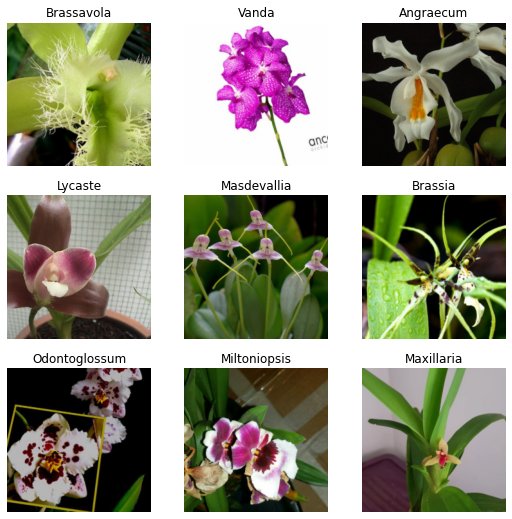

In [93]:
# Now check our images
dls.show_batch(max_n=9)

## Create our Learner

Now we create our Learner, which handles the training and validation loops. In this case, we'll use a pretrained ResNet-50 from the PyTorch model zoo. The `cnn_learner` automatically cuts the final fully connected layers of the pretrained network (which have the original label outputs) and applies a new custom head network to the main pretrained body, with the correct amount of outputs, based on the number of labels in the dataset. 

In [94]:
learn = cnn_learner(dls, resnet50, pretrained=True,
                    loss_func=CrossEntropyLossFlat(),
                    opt_func=Adam,
                    metrics=accuracy)

## Find our Learning Rate

A key element to training a neural network quickly and to high accuracy is having an optimum learning rate for the loss function optimizer (in this case Adam) at the right time during training. fastai makes choosing this learning rate and instantiating a ["one-cycle"](https://fastai1.fast.ai/callbacks.one_cycle.html) learning rate very easy (i.e. a single cycle over the course of the entire training, which starts slowly, ramps up to a maximum rate and then reduces in a cosine annealing fashion to zero). In addition, this inversely cycles the momentum of the Adam optimizer.

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


SuggestedLRs(lr_min=0.005754399299621582, lr_steep=0.0010000000474974513)

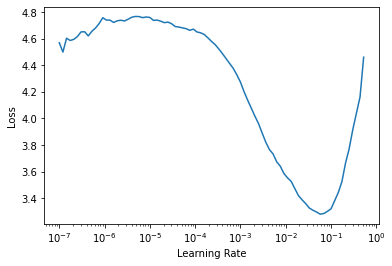

In [9]:
learn.lr_find(suggestions=True)

## Train Our Model

Now we've found a good learning rate, we can train the head of our model. At this point the pretrained model's parameters are still frozen, other than the Batch Norm layers, which allows the pretrained network to act as a fixed-feature extractor for the new custom head.

### Train head

In [95]:
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.845518,1.423715,0.599505,01:24
1,1.730574,1.151923,0.693642,01:23
2,1.225178,0.995854,0.725021,01:23
3,0.976378,0.919860,0.746490,01:24
4,0.751894,0.834673,0.772915,01:24
5,0.610444,0.807859,0.784476,01:25
6,0.491962,0.770431,0.780347,01:25
7,0.416870,0.768377,0.791907,01:26
8,0.369887,0.764954,0.796036,01:27
9,0.346570,0.751820,0.799339,01:27


### Unfreeze and train base layers

An accuracy of 80% is not bad for 10 epochs, given the variance of the types of species within each genus! Not bad at all. Now let's unfreeze the base model parameters and train the full network.

To do this we also need to find our new learning rate.

In [96]:
learn.unfreeze()

SuggestedLRs(lr_min=2.290867705596611e-05, lr_steep=1.3182567499825382e-06)

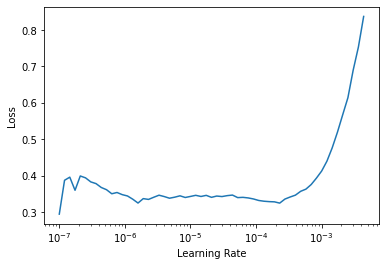

In [97]:
learn.lr_find()

Now that we've got some idea of our new learning rate, we'll apply this using discriminative layer learning. This refers to using a lower learning rate for the base network parameters and a higher learning rate for the custom head, such that we don't "damage" the pre-existing parameters trained for many hours on ImageNet.

In [98]:
learn.fit_one_cycle(20, slice=(6e-6,6e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.453058,0.840666,0.772915,01:29
1,0.651639,1.414684,0.667217,01:28
2,1.032905,1.770493,0.614368,01:29
3,1.065532,2.119179,0.496284,01:29
4,1.099497,1.405346,0.620974,01:28
5,0.964336,1.601728,0.587118,01:29
6,0.923180,1.652808,0.584641,01:29
7,0.867319,0.970786,0.728324,01:28
8,0.805006,1.195390,0.651528,01:29
9,0.647579,1.135085,0.698596,01:30


A final model performance of 83% is quite impressive!

## Plot Confusion Matrix

We can also view our actual vs. predicted labels from the output of the validation set of the model.

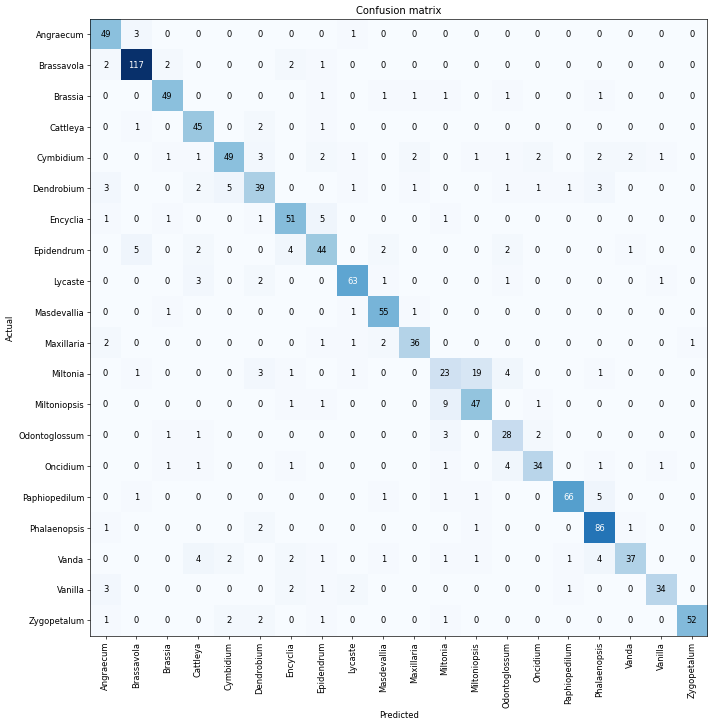

In [100]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

Although we can see that Miltonia is commonly confused with Miltoniopsis (a little unsurpising, given that they were commonly lumped together by botanists [until the 1970s](https://www.aos.org/orchids/orchids-a-to-z/letter-m/miltoniopsis.aspx)), this is a little tricky to read given the amount of labels, so let's plot the highest losses.

We can see here that the losses are very high indeed for the errors in some cases, however, these could well be hybrids of the two genera - fortunately I know an orchid expert who can help me refine this model and perhaps I could turn it into a multi-label classifier instead of single label. For now though, we'll go deploy it, and try it in the real world on some new images and refine later.

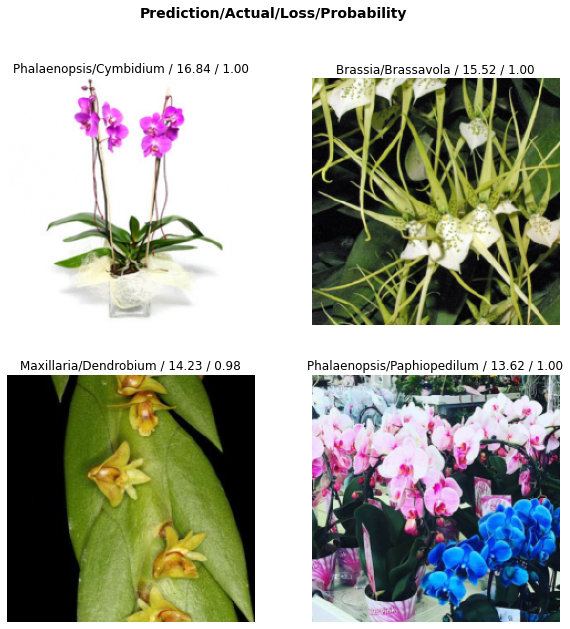

In [107]:
interp.plot_top_losses(4, nrows=2, figsize=(10,10))

## Export and upload the learner to a Google Cloud Storage Bucket for the app

The next stage is to export our `Learner`, such that we can use it in the app for predictions. We'll also upload this to a Google Cloud Storage Bucket, such that the app script can access and download it during deployment.

In [108]:
learn.export()

In [109]:
from google.colab import auth
auth.authenticate_user()

# set project id
project_id = 'project-id'
!gcloud config set project {project_id}

# bucket name
bucket_name = 'project-bucket-name'

# copy to our bucket
!gsutil cp "/content/export.pkl" gs://{bucket_name}/

Updated property [core/project].
Copying file:///content/export.pkl [Content-Type=application/octet-stream]...
\
Operation completed over 1 objects/98.9 MiB.                                     


## List dependencies for Render deployment

Another critical piece of deploying an app are the dependencies - we need to make sure we're deploying the Docker container with the same library dependencies that we trained the app on. These are straightforward to see within your Notebook environment.

In [110]:
!pip list

Package                       Version        
----------------------------- ---------------
absl-py                       0.10.0         
alabaster                     0.7.12         
albumentations                0.1.12         
altair                        4.1.0          
argon2-cffi                   20.1.0         
asgiref                       3.2.10         
astor                         0.8.1          
astropy                       4.0.1.post1    
astunparse                    1.6.3          
async-generator               1.10           
atari-py                      0.2.6          
atomicwrites                  1.4.0          
attrs                         20.2.0         
audioread                     2.1.8          
autograd                      1.3            
Babel                         2.8.0          
backcall                      0.2.0          
beautifulsoup4                4.6.3          
bleach                        3.1.5          
blis                          0.4.

And let's not forget the Python version for information.

In [111]:
!python --version

Python 3.6.9


## Next Up

Now that we've trained what appears to be a well performing model, let's get on to the deployment to render and creating the front-end flutter app in [Part 2](https://mikful.github.io/blog/fastai/jupyter/render/flutter/2020/09/16/orchid-classifier-fastai-render-flutter-2.html).